In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
threshold_for_results = 0.5

# RAM workable at 5% rescaled
#rescaled_size = (54,96)

# Grayscale has 1 dim (Can drop it)
# Width, Height
#input_shape = (200, 100)
#flatten_shape = (20000)

# RGB has 3 dims
input_shape = (None, 100, 200, 3)
flatten_shape = (None, 20000, 3)
flatten_value = 20000

print("Shape Ready")

Shape Ready


In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020

from numpy.random import seed
seed(seed_value)

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_random_seed(seed_value)

print(tf.__version__)
print("Seed values re-set to 2019.")

1.15.0
Seed values re-set to 2019.


In [0]:
# Imports to read images
from matplotlib import pyplot as plt
#from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
from skimage.color import rgb2gray
import glob
from skimage.io import imread
print("Import Done")

Import Done


In [0]:
# Imports for model building from tutorial site
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.layers import cudnn_recurrent
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm
print("Import Done")

Import Done


Using TensorFlow backend.


In [0]:
# Imports from previous model building
%matplotlib inline
import matplotlib.pyplot as plt
#import tensorflow as tf
#!pip install numpy==1.16.1
import numpy as np

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, GRU, Embedding
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

print(tf.__version__)
print("Import Done")

1.15.0
Import Done


In [0]:
# Imports for image downscaling because it takes too much RAM
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
print("Import Done")

Import Done


In [0]:
# Test code for rescaling
# Original Size = (200,100) Width, Height
# Total Images = 706

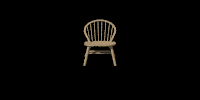

In [0]:
# Load first image for viewing
image1 = image.load_img('/content/drive/My Drive/Colab Notebooks/4) Coloured Pictures/ws_chair_colour000.png', grayscale=False)
image1

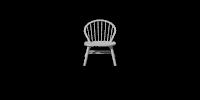

In [0]:
# Load last image for viewing
image1 = image.load_img('/content/drive/My Drive/Colab Notebooks/4) Coloured Pictures/ws_chair_colour705.png', grayscale=False)
image1

In [0]:
# Training Set
# To split the data to train 7 models, such that later models have more exposure to more data
# The pictures are NOT to be shuffled, the pictures are modified with increasing variance (in terms of rotation)
# The rotation is only done in one direction, therefore pictures that are the same (rotated 180 degrees) will be removed

# Model 1: Only the original unmodified image (001)
# Model 2: 000 ~ 141
# Model 3: 000 ~ 282
# Model 4: 000 ~ 423
# Model 5: 000 ~ 564
# Model 6: 000 ~ 696 # Leave out last 10
# Model 7: 101, 201, 402 (RGB peak when isolated)

# Test Set
# All models are tested on the entire dataset of 706

In [0]:
# Data input
# Read in the training images
# Values are in RGB from 0 to 255, divide by 255 to get values from 0 to 1

train_image = []
for i in tqdm(range(0,706)):
    if i < 10:
      stringIndex = "00" + str(i)
    elif i < 100:
      stringIndex = "0" + str(i)
    else:
      stringIndex = str(i)

    # Parameter if needed: target_size = rescaled_size
    img = image.load_img('/content/drive/My Drive/Colab Notebooks/4) Coloured Pictures/ws_chair_colour' + stringIndex + '.png', grayscale=False)

    img = image.img_to_array(img)
    img = img/255 
    train_image.append(img)

print(len(train_image))
#X = np.array(train_image) # wait for train face image below

100%|██████████| 706/706 [04:52<00:00,  2.42it/s]

706


In [0]:
X = np.array(train_image) # Transfer

# Create y values for training data
# All are 1s, since all are pictures of target chair
y = [1] * 706
y = np.asarray(y)

print(type(X))
print(X.shape)
print(len(X)) # Total length should be 921 training data

print(type(y))
print(y.shape)
print(len(y)) # Total length should be 921 training data


<class 'numpy.ndarray'>
(706, 100, 200, 3)
706
<class 'numpy.ndarray'>
(706,)
706


In [0]:
print(len(X))
print(X.shape)

print(len(y))
print(y.shape)

706
(706, 100, 200, 3)
706
(706,)


In [0]:
print(X.shape)
#index = [100,200,401]
a = X[100]
b = X[200]
c = X[401]
#XTrain_for_model7 = np.array(X[100],X[200],X[401])
abc = [a,b,c]
XTrain_for_model7 = np.array(abc)
print(XTrain_for_model7.shape)

(706, 100, 200, 3)
(3, 100, 200, 3)


In [0]:
print(X.shape)
XVal_for_model7 = np.delete(X, 100,0)
XVal_for_model7 = np.delete(XVal_for_model7, 200,0)
XVal_for_model7 = np.delete(XVal_for_model7, 401,0)
print(XVal_for_model7.shape)

(706, 100, 200, 3)
(703, 100, 200, 3)


In [0]:
# Split into 6 portions, with the rest as validation sets
X_train1 = X[0:1]
X_train2 = X[0:141]
X_train3 = X[0:282]
X_train4 = X[0:423]
X_train5 = X[0:564]
X_train6 = X[0:695] # Remove last 10 images to set as validation
X_train7 = XTrain_for_model7 # Trained on the 3 pictures with RGB at peak values in isolation

## Note: Should train on the RGB peak pictures, not last 2

# Note: Background data is not necessarily in strict increasing variance magnitude, subjective.
# However, some of the starting pictures where the chair colour is so dark, it is almost visible
# Therefore, this data should be in decreasing variance magnitude
# if we assume that bright objects are easily visible and vice versa

X_train1_flatten = X_train1.reshape(1,flatten_value, 3)
X_train2_flatten = X_train2.reshape(len(X_train2),flatten_value, 3)
X_train3_flatten = X_train3.reshape(len(X_train3),flatten_value, 3)
X_train4_flatten = X_train4.reshape(len(X_train4),flatten_value, 3)
X_train5_flatten = X_train5.reshape(len(X_train5),flatten_value, 3)
X_train6_flatten = X_train6.reshape(len(X_train6),flatten_value, 3)
X_train7_flatten = X_train7.reshape(len(X_train7),flatten_value, 3)

y_train1 = y[0:1]
y_train2 = y[0:141]
y_train3 = y[0:282]
y_train4 = y[0:423]
y_train5 = y[0:564]
y_train6 = y[0:695]
y_train7 = y[702:705] # Get 3 values

X_val1 = X[1:706]
X_val2 = X[141:706]
X_val3 = X[282:706]
X_val4 = X[423:706]
X_val5 = X[564:706]
X_val6 = X[695:706]
X_val7 = XVal_for_model7

X_val1_flatten = X_val1.reshape(len(X_val1),flatten_value, 3)
X_val2_flatten = X_val2.reshape(len(X_val2),flatten_value, 3)
X_val3_flatten = X_val3.reshape(len(X_val3),flatten_value, 3)
X_val4_flatten = X_val4.reshape(len(X_val4),flatten_value, 3)
X_val5_flatten = X_val5.reshape(len(X_val5),flatten_value, 3)
X_val6_flatten = X_val6.reshape(len(X_val6),flatten_value, 3)
X_val7_flatten = X_val7.reshape(len(X_val7),flatten_value, 3)

y_val1 = y[1:706]
y_val2 = y[141:706]
y_val3 = y[282:706]
y_val4 = y[423:706]
y_val5 = y[564:706]
y_val6 = y[695:706]
y_val7 = y[0:703]

print("X Length")
print(len(X))

print("X Train Length")
print(len(X_train1))
print(len(X_train2))
print(len(X_train3))
print(len(X_train4))
print(len(X_train5))
print(len(X_train6))
print(len(X_train7))

print("X_train shape")
print(X_train1.shape)
print(X_train2.shape)
print(X_train3.shape)
print(X_train4.shape)
print(X_train5.shape)
print(X_train6.shape)
print(X_train7.shape)

print("X_train flatten")
print(X_train1_flatten.shape)
print(X_train2_flatten.shape)
print(X_train3_flatten.shape)
print(X_train4_flatten.shape)
print(X_train5_flatten.shape)
print(X_train6_flatten.shape)
print(X_train7_flatten.shape)

print("X_val shape")
print(X_val1.shape)
print(X_val2.shape)
print(X_val3.shape)
print(X_val4.shape)
print(X_val5.shape)
print(X_val6.shape)
print(X_val7.shape)

print("X_val flatten")
print(X_val1_flatten.shape)
print(X_val2_flatten.shape)
print(X_val3_flatten.shape)
print(X_val4_flatten.shape)
print(X_val5_flatten.shape)
print(X_val6_flatten.shape)
print(X_val7_flatten.shape)

print("Data Prepared")

X Length
706
X Train Length
1
141
282
423
564
695
3
X_train shape
(1, 100, 200, 3)
(141, 100, 200, 3)
(282, 100, 200, 3)
(423, 100, 200, 3)
(564, 100, 200, 3)
(695, 100, 200, 3)
(3, 100, 200, 3)
X_train flatten
(1, 20000, 3)
(141, 20000, 3)
(282, 20000, 3)
(423, 20000, 3)
(564, 20000, 3)
(695, 20000, 3)
(3, 20000, 3)
X_val shape
(705, 100, 200, 3)
(565, 100, 200, 3)
(424, 100, 200, 3)
(283, 100, 200, 3)
(142, 100, 200, 3)
(11, 100, 200, 3)
(703, 100, 200, 3)
X_val flatten
(705, 20000, 3)
(565, 20000, 3)
(424, 20000, 3)
(283, 20000, 3)
(142, 20000, 3)
(11, 20000, 3)
(703, 20000, 3)
Data Prepared


In [0]:
print("y_train")
print(y_train1.shape)
print(y_train2.shape)
print(y_train3.shape)
print(y_train4.shape)
print(y_train5.shape)
print(y_train6.shape)
print(y_train7.shape)

print("y_val")
print(y_val1.shape)
print(y_val2.shape)
print(y_val3.shape)
print(y_val4.shape)
print(y_val5.shape)
print(y_val6.shape)
print(y_val7.shape)

y_train
(1,)
(141,)
(282,)
(423,)
(564,)
(695,)
(3,)
y_val
(705,)
(565,)
(424,)
(283,)
(142,)
(11,)
(703,)


In [0]:
# Clear Variables no longer needed
train_image = None
X = None
y = None
a = None
b = None
c = None
abc = None
XTrain_for_model7 = None
XVal_for_model7 =None

In [0]:
###########################################################################################################################
#------------------------------------------------------------Model Building-----------------------------------------------#
###########################################################################################################################

In [0]:
# User defined parameters
batch_size_user = 2
epoch_user = 1
times_to_loop_model = 3

print("User defined parameters set")
print(batch_size_user)
print(epoch_user)
print(times_to_loop_model)

User defined parameters set
2
1
3


In [0]:
###########################################################################################################################
#------------------------------------------------------------Dense Model-----------------------------------------------#
###########################################################################################################################





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 120002    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1 samples, validate on 705 samples
Epoch 1/1





1/1 [==============================] - 10s 10s/step - loss: 0.6931 - a

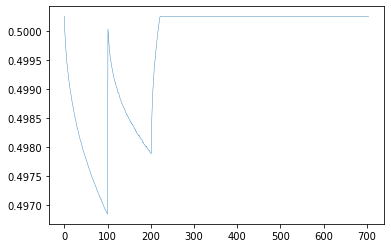

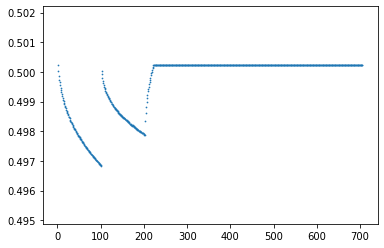

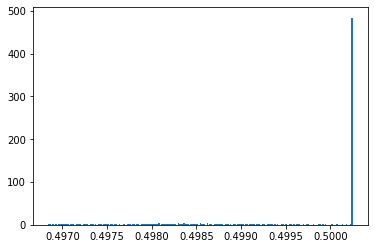

Average value is:  0.49966124
Total Predicted Positive:  501  out of  705
71.06382978723404 %
Epoch:  2
Train on 1 samples, validate on 705 samples
Epoch 1/1
1/1 [==============================] - 1s 637ms/step - loss: 0.6926 - acc: 1.0000 - val_loss: 0.6933 - val_acc: 0.7050
(705, 1)


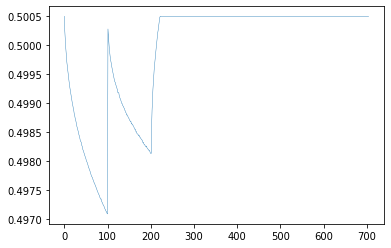

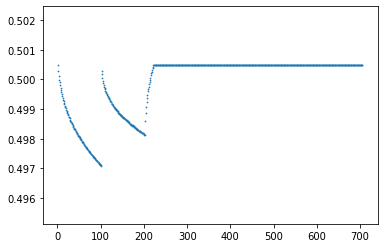

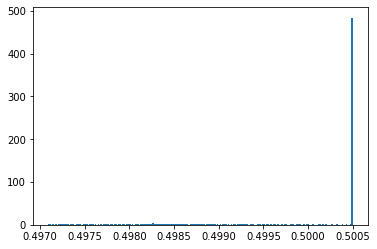

Average value is:  0.49991134
Total Predicted Positive:  501  out of  705
71.06382978723404 %
Epoch:  3
Train on 1 samples, validate on 705 samples
Epoch 1/1
1/1 [==============================] - 1s 629ms/step - loss: 0.6921 - acc: 1.0000 - val_loss: 0.6928 - val_acc: 0.7191
(705, 1)


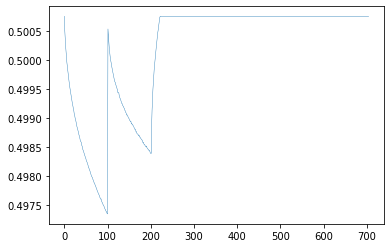

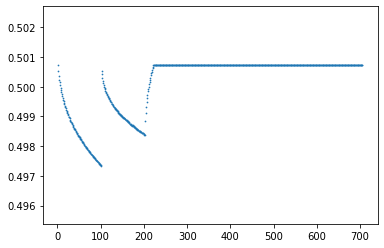

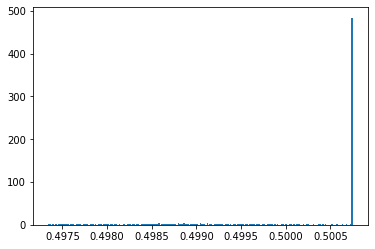

Average value is:  0.5001613
Total Predicted Positive:  501  out of  705
71.06382978723404 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 1
## create the model
modelDense1 = 0
modelDense1 = Sequential()
modelDense1.add(Flatten())
modelDense1.add(Dense(2, activation='relu'))
modelDense1.add(Dense(2, activation='relu'))
modelDense1.add(Dense(1, activation='sigmoid'))
modelDense1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense1.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense1.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense1.fit(X_train1, y_train1, epochs=1, batch_size=batch_size_user, validation_data = (X_val1, y_val1),verbose=1)

  # Test the model
  y_pred = modelDense1.predict(X_val1)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 120002    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 141 samples, validate on 565 samples
Epoch 1/1
141/141 [==============================] - 1s 7ms/step - loss: 0.6763 - acc: 0.9858 - val_loss: 0.6585 - val_acc: 1.0000
(565, 1)


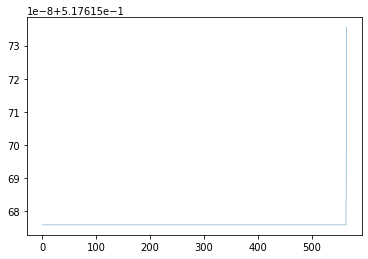

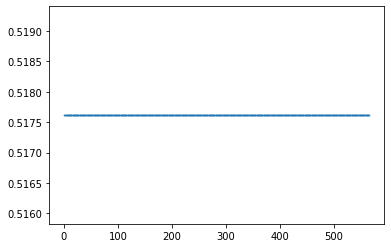

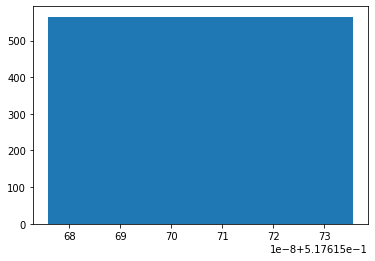

Average value is:  0.51761574
Total Predicted Positive:  1  out of  565
0.17699115044247787 %
Epoch:  2
Train on 141 samples, validate on 565 samples
Epoch 1/1
141/141 [==============================] - 1s 5ms/step - loss: 0.6422 - acc: 1.0000 - val_loss: 0.6255 - val_acc: 1.0000
(565, 1)


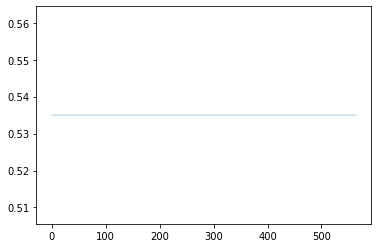

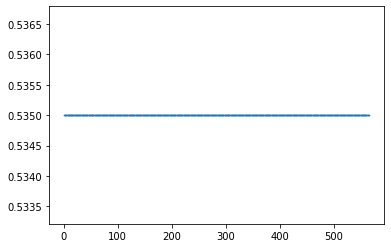

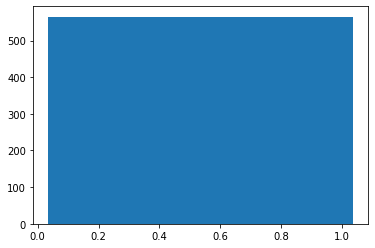

Average value is:  0.5350024
Total Predicted Positive:  565  out of  565
100.0 %
Epoch:  3
Train on 141 samples, validate on 565 samples
Epoch 1/1
141/141 [==============================] - 1s 5ms/step - loss: 0.6101 - acc: 1.0000 - val_loss: 0.5943 - val_acc: 1.0000
(565, 1)


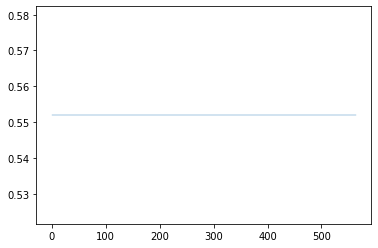

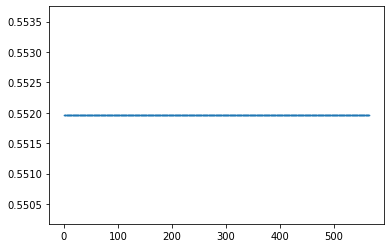

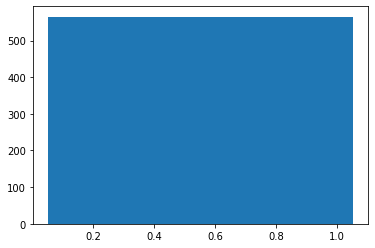

Average value is:  0.5519614
Total Predicted Positive:  565  out of  565
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 2
## create the model
modelDense2 = 0
modelDense2 = Sequential()
modelDense2.add(Flatten())
modelDense2.add(Dense(2, activation='relu'))
modelDense2.add(Dense(2, activation='relu'))
modelDense2.add(Dense(1, activation='sigmoid'))
modelDense2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense2.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense2.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense2.fit(X_train2, y_train2, epochs=1, batch_size=batch_size_user, validation_data = (X_val2, y_val2),verbose=1)

  # Test the model
  y_pred = modelDense2.predict(X_val2)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 120002    
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 282 samples, validate on 424 samples
Epoch 1/1
282/282 [==============================] - 1s 4ms/step - loss: 0.6593 - acc: 0.9894 - val_loss: 0.6260 - val_acc: 1.0000
(424, 1)


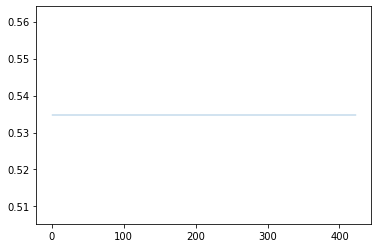

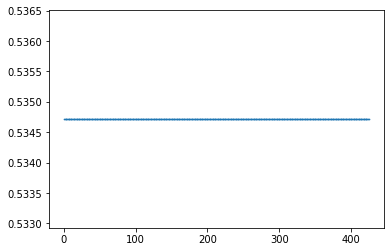

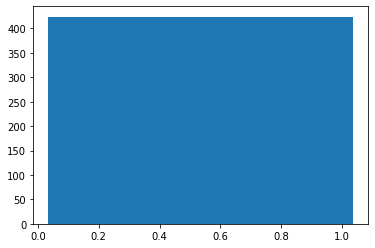

Average value is:  0.53471607
Total Predicted Positive:  0  out of  424
0.0 %
Epoch:  2
Train on 282 samples, validate on 424 samples
Epoch 1/1
282/282 [==============================] - 1s 3ms/step - loss: 0.5956 - acc: 1.0000 - val_loss: 0.5658 - val_acc: 1.0000
(424, 1)


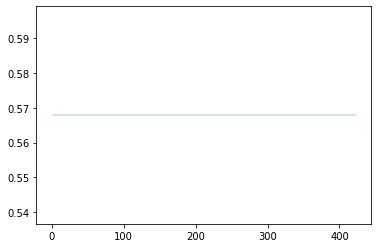

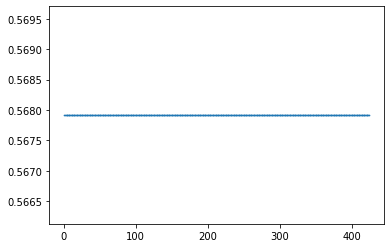

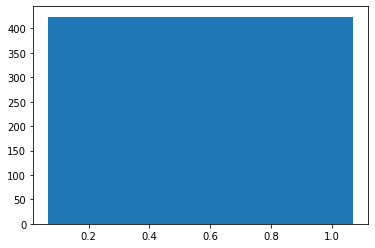

Average value is:  0.56791484
Total Predicted Positive:  0  out of  424
0.0 %
Epoch:  3
Train on 282 samples, validate on 424 samples
Epoch 1/1
282/282 [==============================] - 1s 3ms/step - loss: 0.5385 - acc: 1.0000 - val_loss: 0.5119 - val_acc: 1.0000
(424, 1)


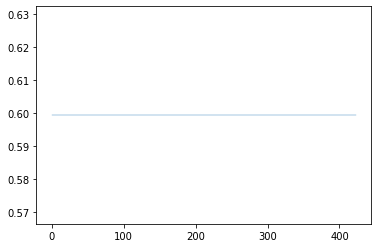

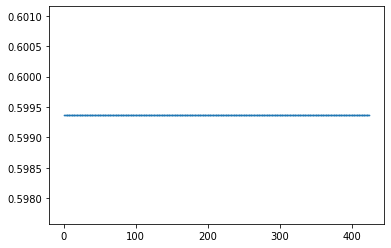

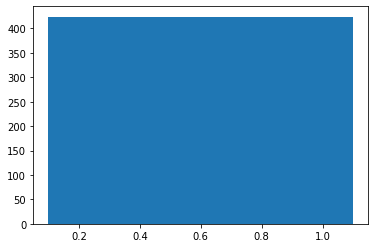

Average value is:  0.5993676
Total Predicted Positive:  424  out of  424
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 3
## create the model
modelDense3 = 0
modelDense3 = Sequential()
modelDense3.add(Flatten())
modelDense3.add(Dense(2, activation='relu'))
modelDense3.add(Dense(2, activation='relu'))
modelDense3.add(Dense(1, activation='sigmoid'))
modelDense3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense3.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense3.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense3.fit(X_train3, y_train3, epochs=1, batch_size=batch_size_user, validation_data = (X_val3, y_val3),verbose=1)

  # Test the model
  y_pred = modelDense3.predict(X_val3)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 120002    
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 423 samples, validate on 283 samples
Epoch 1/1
423/423 [==============================] - 1s 3ms/step - loss: 0.6430 - acc: 0.9929 - val_loss: 0.5949 - val_acc: 1.0000
(283, 1)


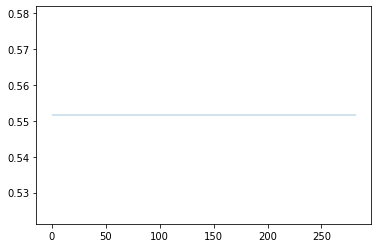

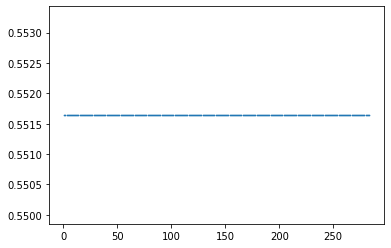

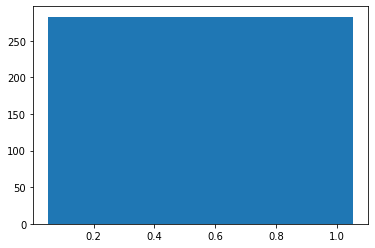

Average value is:  0.5516416
Total Predicted Positive:  283  out of  283
100.0 %
Epoch:  2
Train on 423 samples, validate on 283 samples
Epoch 1/1
423/423 [==============================] - 1s 2ms/step - loss: 0.5523 - acc: 1.0000 - val_loss: 0.5115 - val_acc: 1.0000
(283, 1)


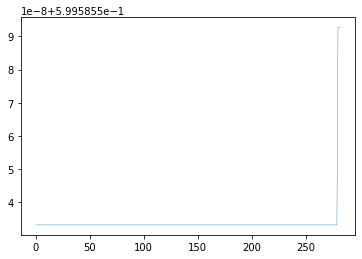

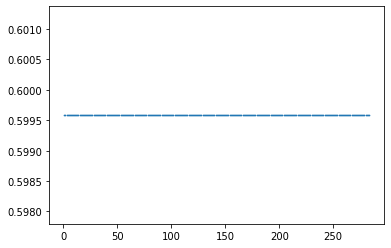

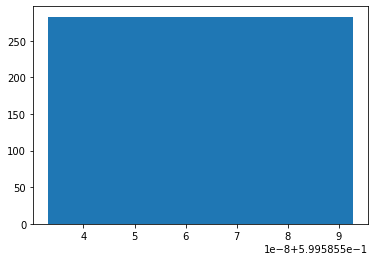

Average value is:  0.59958553
Total Predicted Positive:  283  out of  283
100.0 %
Epoch:  3
Train on 423 samples, validate on 283 samples
Epoch 1/1
423/423 [==============================] - 1s 2ms/step - loss: 0.4756 - acc: 1.0000 - val_loss: 0.4411 - val_acc: 1.0000
(283, 1)


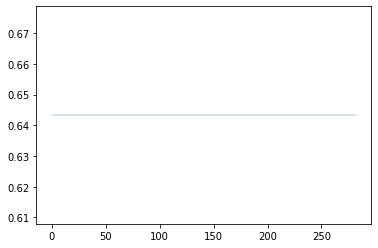

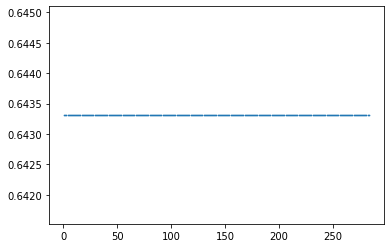

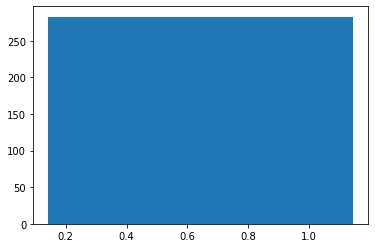

Average value is:  0.6433101
Total Predicted Positive:  283  out of  283
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 4
## create the model
modelDense4 = 0
modelDense4 = Sequential()
modelDense4.add(Flatten())
modelDense4.add(Dense(2, activation='relu'))
modelDense4.add(Dense(2, activation='relu'))
modelDense4.add(Dense(1, activation='sigmoid'))
modelDense4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense4.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense4.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense4.fit(X_train4, y_train4, epochs=1, batch_size=batch_size_user, validation_data = (X_val4, y_val4),verbose=1)

  # Test the model
  y_pred = modelDense4.predict(X_val4)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 120002    
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 564 samples, validate on 142 samples
Epoch 1/1
564/564 [==============================] - 2s 3ms/step - loss: 0.6274 - acc: 0.9929 - val_loss: 0.5658 - val_acc: 1.0000
(142, 1)


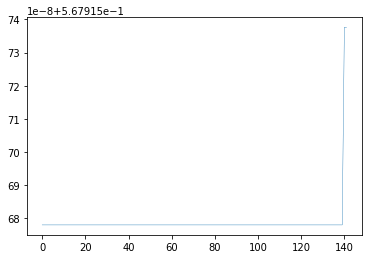

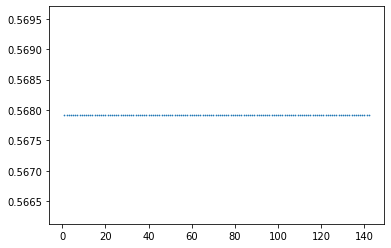

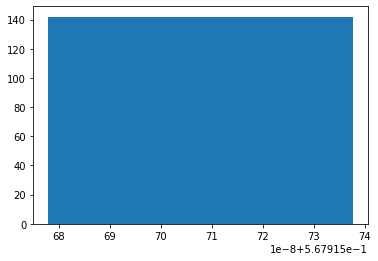

Average value is:  0.56791574
Total Predicted Positive:  2  out of  142
1.4084507042253522 %
Epoch:  2
Train on 564 samples, validate on 142 samples
Epoch 1/1
564/564 [==============================] - 1s 2ms/step - loss: 0.5130 - acc: 1.0000 - val_loss: 0.4637 - val_acc: 1.0000
(142, 1)


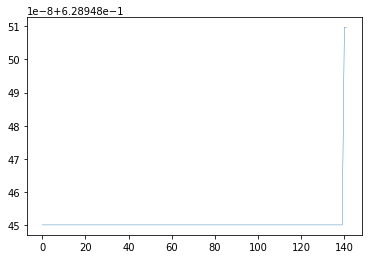

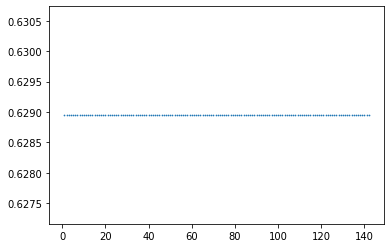

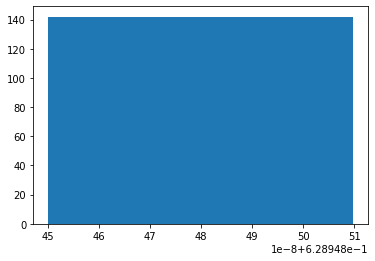

Average value is:  0.62894845
Total Predicted Positive:  142  out of  142
100.0 %
Epoch:  3
Train on 564 samples, validate on 142 samples
Epoch 1/1
564/564 [==============================] - 1s 2ms/step - loss: 0.4216 - acc: 1.0000 - val_loss: 0.3823 - val_acc: 1.0000
(142, 1)


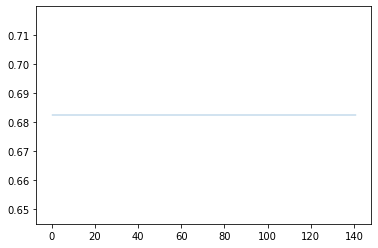

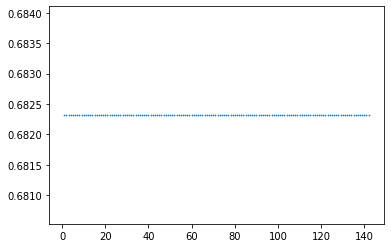

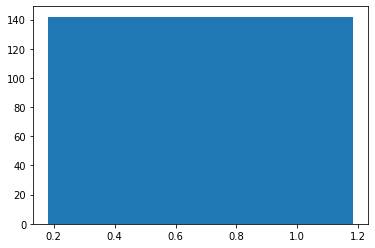

Average value is:  0.6823168
Total Predicted Positive:  142  out of  142
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 5
## create the model
modelDense5 = 0
modelDense5 = Sequential()
modelDense5.add(Flatten())
modelDense5.add(Dense(2, activation='relu'))
modelDense5.add(Dense(2, activation='relu'))
modelDense5.add(Dense(1, activation='sigmoid'))
modelDense5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense5.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense5.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense5.fit(X_train5, y_train5, epochs=1, batch_size=batch_size_user, validation_data = (X_val5, y_val5),verbose=1)

  # Test the model
  y_pred = modelDense5.predict(X_val5)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 120002    
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 695 samples, validate on 11 samples
Epoch 1/1
695/695 [==============================] - 2s 3ms/step - loss: 0.6134 - acc: 0.9942 - val_loss: 0.5398 - val_acc: 1.0000
(11, 1)


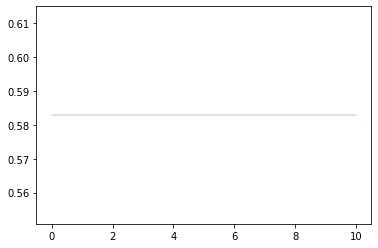

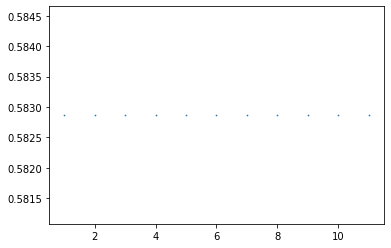

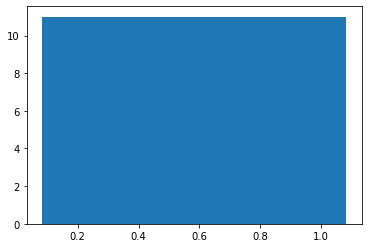

Average value is:  0.5828653
Total Predicted Positive:  11  out of  11
100.0 %
Epoch:  2
Train on 695 samples, validate on 11 samples
Epoch 1/1
695/695 [==============================] - 1s 2ms/step - loss: 0.4791 - acc: 1.0000 - val_loss: 0.4233 - val_acc: 1.0000
(11, 1)


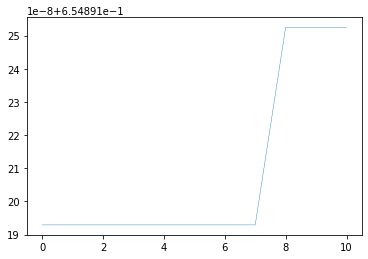

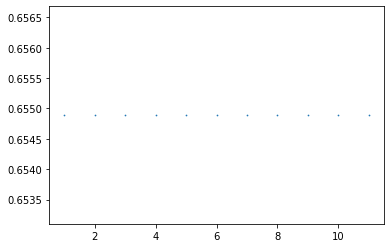

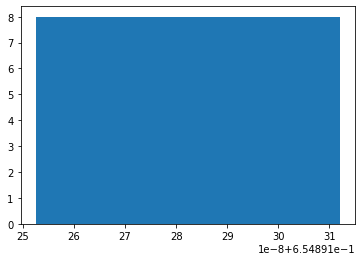

Average value is:  0.6548912
Total Predicted Positive:  11  out of  11
100.0 %
Epoch:  3
Train on 695 samples, validate on 11 samples
Epoch 1/1
695/695 [==============================] - 1s 2ms/step - loss: 0.3773 - acc: 1.0000 - val_loss: 0.3351 - val_acc: 1.0000
(11, 1)


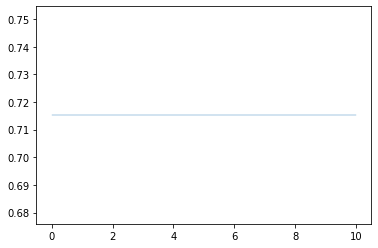

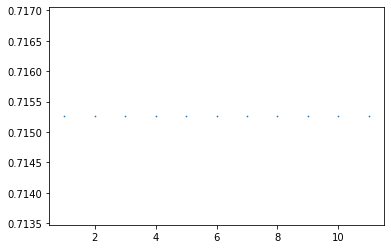

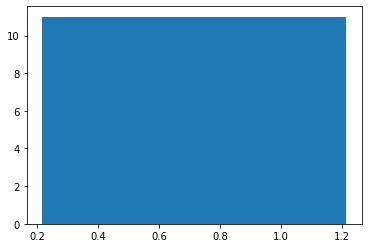

Average value is:  0.7152611
Total Predicted Positive:  11  out of  11
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 6
## create the model
modelDense6 = 0
modelDense6 = Sequential()
modelDense6.add(Flatten())
modelDense6.add(Dense(2, activation='relu'))
modelDense6.add(Dense(2, activation='relu'))
modelDense6.add(Dense(1, activation='sigmoid'))
modelDense6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense6.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense6.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense6.fit(X_train6, y_train6, epochs=1, batch_size=batch_size_user, validation_data = (X_val6, y_val6),verbose=1)

  # Test the model
  y_pred = modelDense6.predict(X_val6)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 120002    
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 3 samples, validate on 703 samples
Epoch 1/1
3/3 [==============================] - 1s 390ms/step - loss: 0.6968 - acc: 0.3333 - val_loss: 0.6921 - val_acc: 1.0000
(703, 1)


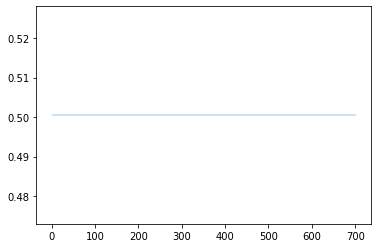

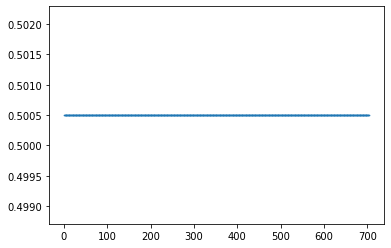

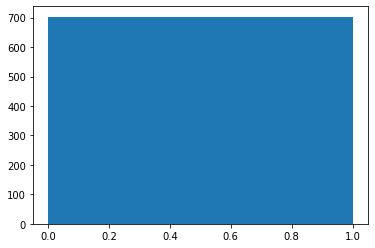

Average value is:  0.5004999
Total Predicted Positive:  703  out of  703
100.0 %
Epoch:  2
Train on 3 samples, validate on 703 samples
Epoch 1/1
3/3 [==============================] - 1s 219ms/step - loss: 0.6920 - acc: 1.0000 - val_loss: 0.6911 - val_acc: 1.0000
(703, 1)


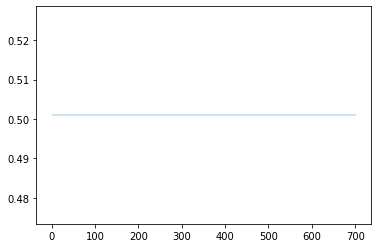

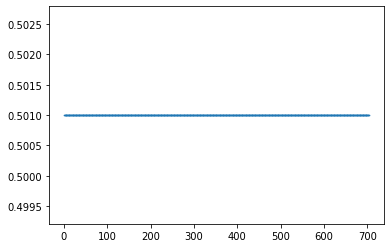

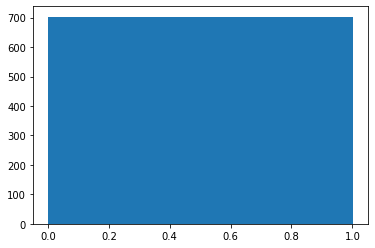

Average value is:  0.50099987
Total Predicted Positive:  0  out of  703
0.0 %
Epoch:  3
Train on 3 samples, validate on 703 samples
Epoch 1/1
3/3 [==============================] - 1s 226ms/step - loss: 0.6910 - acc: 1.0000 - val_loss: 0.6902 - val_acc: 1.0000
(703, 1)


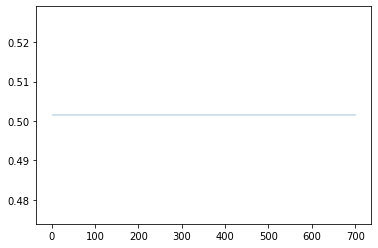

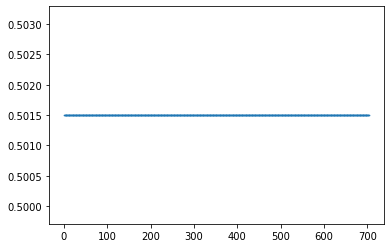

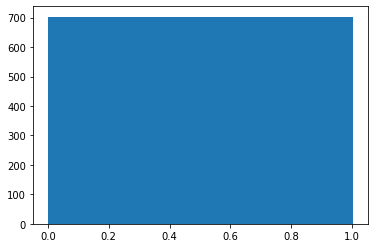

Average value is:  0.5014996
Total Predicted Positive:  703  out of  703
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 7
## create the model
modelDense7 = 0
modelDense7 = Sequential()
modelDense7.add(Flatten())
modelDense7.add(Dense(2, activation='relu'))
modelDense7.add(Dense(2, activation='relu'))
modelDense7.add(Dense(1, activation='sigmoid'))
modelDense7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense7.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense7.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense7.fit(X_train7, y_train7, epochs=1, batch_size=batch_size_user, validation_data = (X_val7, y_val7),verbose=1)

  # Test the model
  y_pred = modelDense7.predict(X_val7)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

In [0]:
###########################################################################################################################
#------------------------------------------------------------CNN Model-----------------------------------------------#
###########################################################################################################################


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 19404)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 1 samples, validate on 705 samples
Epoch 1/1
1/1 [==============================] - 6s 6s/step - loss: 0.6687 - acc: 1.0000 - val_loss: 0.6111 - val_acc: 1.0000
(705, 1)


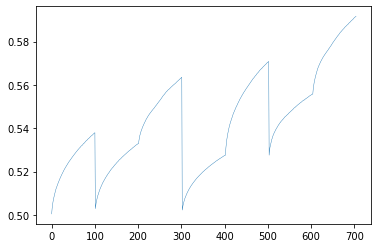

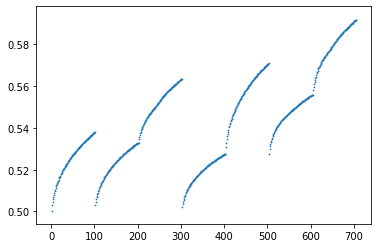

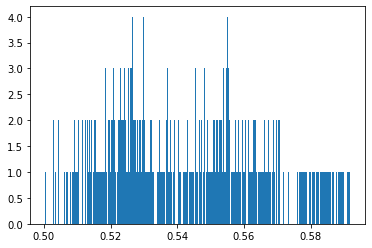

Average value is:  0.54320157
Total Predicted Positive:  347  out of  705
49.219858156028366 %
Epoch:  2
Train on 1 samples, validate on 705 samples
Epoch 1/1
1/1 [==============================] - 1s 660ms/step - loss: 0.5636 - acc: 1.0000 - val_loss: 0.5407 - val_acc: 1.0000
(705, 1)


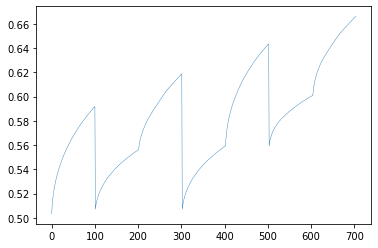

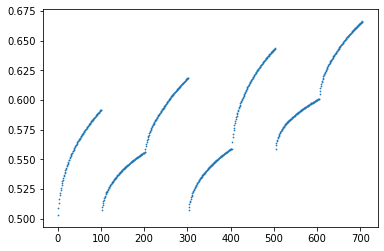

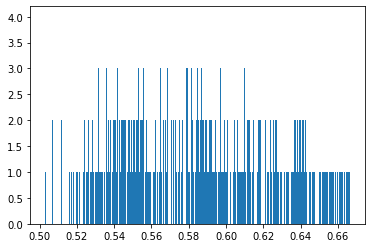

Average value is:  0.58366
Total Predicted Positive:  355  out of  705
50.35460992907801 %
Epoch:  3
Train on 1 samples, validate on 705 samples
Epoch 1/1
1/1 [==============================] - 1s 654ms/step - loss: 0.4670 - acc: 1.0000 - val_loss: 0.4731 - val_acc: 1.0000
(705, 1)


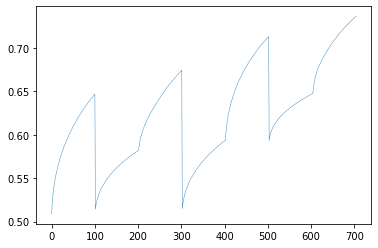

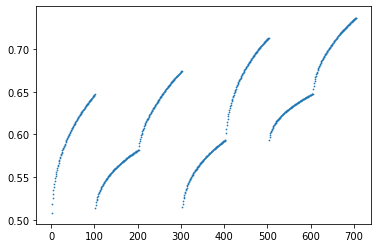

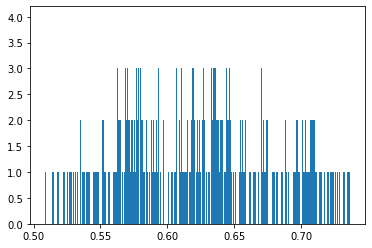

Average value is:  0.6254734
Total Predicted Positive:  363  out of  705
51.48936170212765 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 1
## create the model
modelCNN1 = 0
modelCNN1 = Sequential()
modelCNN1.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN1.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN1.add(Flatten())
modelCNN1.add(Dense(1, activation='sigmoid'))
modelCNN1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN1.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN1.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN1.fit(X_train1, y_train1, epochs=1, batch_size=batch_size_user, validation_data = (X_val1, y_val1),verbose=1)

  # Test the model
  y_pred = modelCNN1.predict(X_val1)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 19404)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 141 samples, validate on 565 samples
Epoch 1/1
141/141 [==============================] - 2s 11ms/step - loss: 0.0760 - acc: 0.9929 - val_loss: 1.4643e-05 - val_acc: 1.0000
(565, 1)


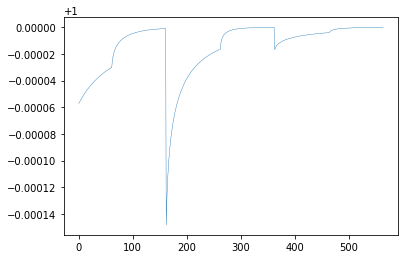

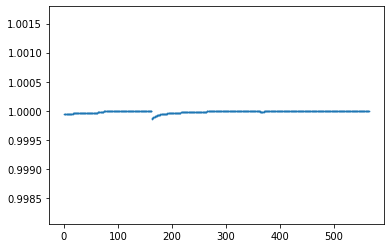

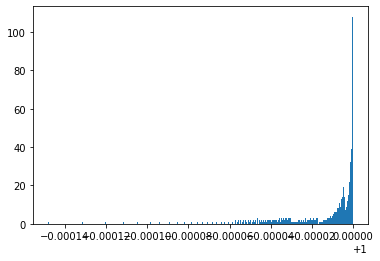

Average value is:  0.99998534
Total Predicted Positive:  391  out of  565
69.20353982300885 %
Epoch:  2
Train on 141 samples, validate on 565 samples
Epoch 1/1
141/141 [==============================] - 1s 6ms/step - loss: 3.0903e-05 - acc: 1.0000 - val_loss: 1.1926e-05 - val_acc: 1.0000
(565, 1)


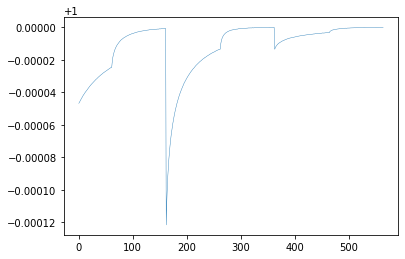

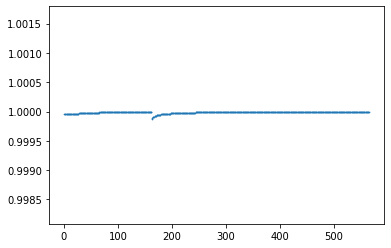

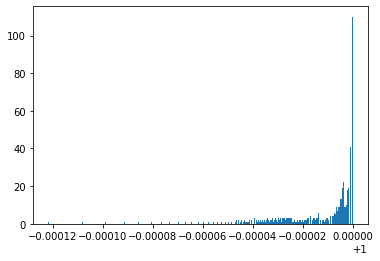

Average value is:  0.99998814
Total Predicted Positive:  391  out of  565
69.20353982300885 %
Epoch:  3
Train on 141 samples, validate on 565 samples
Epoch 1/1
141/141 [==============================] - 1s 5ms/step - loss: 2.6242e-05 - acc: 1.0000 - val_loss: 1.0089e-05 - val_acc: 1.0000
(565, 1)


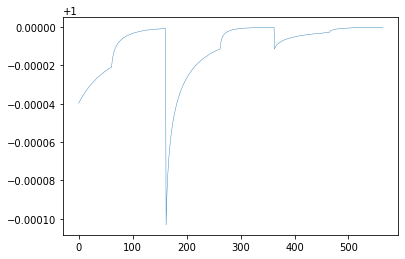

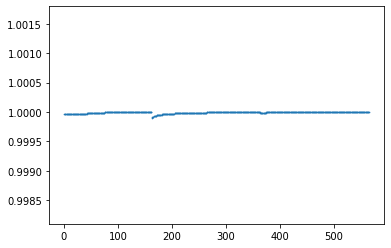

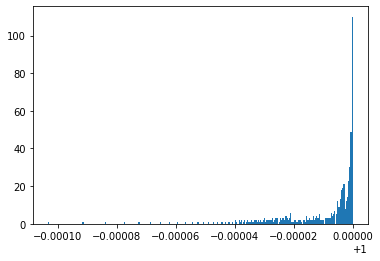

Average value is:  0.9999899
Total Predicted Positive:  391  out of  565
69.20353982300885 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 2
## create the model
modelCNN2 = 0
modelCNN2 = Sequential()
modelCNN2.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN2.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN2.add(Flatten())
modelCNN2.add(Dense(1, activation='sigmoid'))
modelCNN2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN2.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN2.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN2.fit(X_train2, y_train2, epochs=1, batch_size=batch_size_user, validation_data = (X_val2, y_val2),verbose=1)

  # Test the model
  y_pred = modelCNN2.predict(X_val2)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 282 samples, validate on 424 samples
Epoch 1/1
282/282 [==============================] - 2s 5ms/step - loss: 0.0373 - acc: 1.0000 - val_loss: 1.2531e-05 - val_acc: 1.0000
(424, 1)


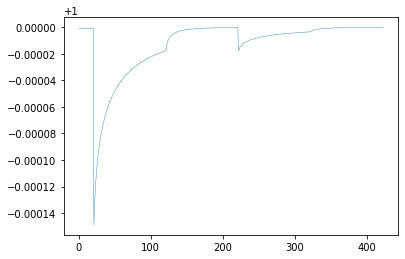

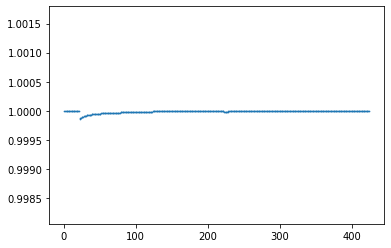

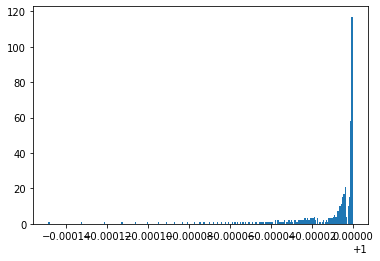

Average value is:  0.9999875
Total Predicted Positive:  315  out of  424
74.29245283018868 %
Epoch:  2
Train on 282 samples, validate on 424 samples
Epoch 1/1
282/282 [==============================] - 1s 3ms/step - loss: 2.2805e-05 - acc: 1.0000 - val_loss: 8.8936e-06 - val_acc: 1.0000
(424, 1)


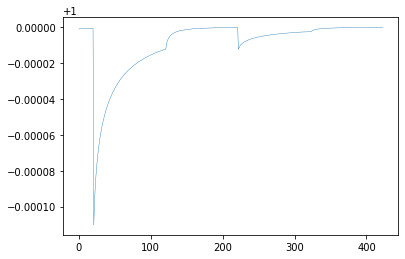

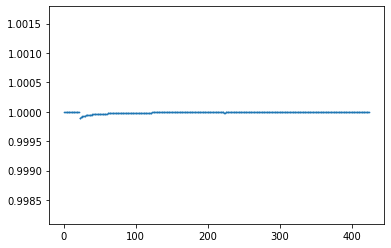

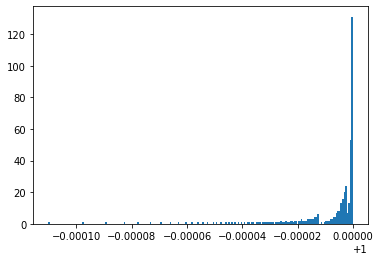

Average value is:  0.9999911
Total Predicted Positive:  315  out of  424
74.29245283018868 %
Epoch:  3
Train on 282 samples, validate on 424 samples
Epoch 1/1
282/282 [==============================] - 1s 3ms/step - loss: 1.6864e-05 - acc: 1.0000 - val_loss: 6.3570e-06 - val_acc: 1.0000
(424, 1)


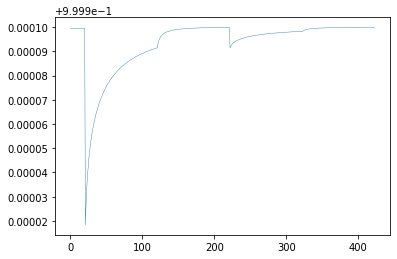

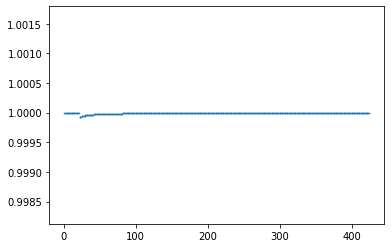

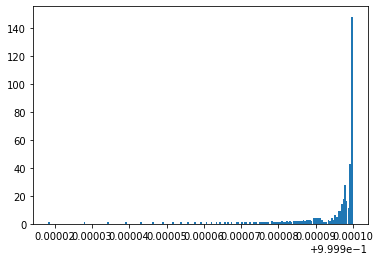

Average value is:  0.9999937
Total Predicted Positive:  316  out of  424
74.52830188679245 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 3
## create the model
modelCNN3 = 0
modelCNN3 = Sequential()
modelCNN3.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN3.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN3.add(Flatten())
modelCNN3.add(Dense(1, activation='sigmoid'))
modelCNN3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN3.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN3.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN3.fit(X_train3, y_train3, epochs=1, batch_size=batch_size_user, validation_data = (X_val3, y_val3),verbose=1)

  # Test the model
  y_pred = modelCNN3.predict(X_val3)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 423 samples, validate on 283 samples
Epoch 1/1
423/423 [==============================] - 2s 4ms/step - loss: 0.0216 - acc: 1.0000 - val_loss: 7.4643e-07 - val_acc: 1.0000
(283, 1)


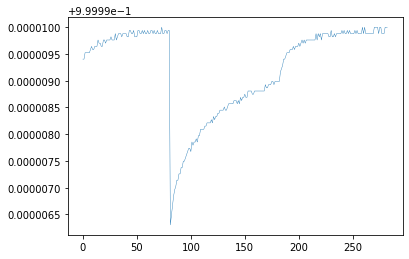

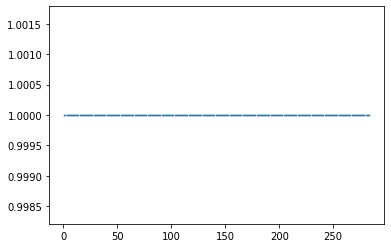

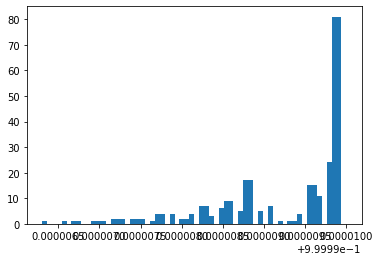

Average value is:  0.9999992
Total Predicted Positive:  180  out of  283
63.60424028268551 %
Epoch:  2
Train on 423 samples, validate on 283 samples
Epoch 1/1
423/423 [==============================] - 1s 2ms/step - loss: 6.6992e-06 - acc: 1.0000 - val_loss: 6.1205e-07 - val_acc: 1.0000
(283, 1)


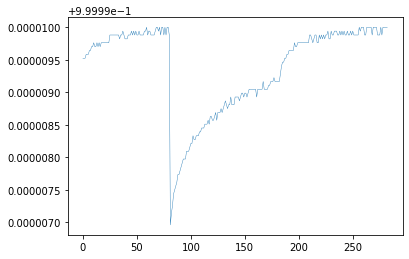

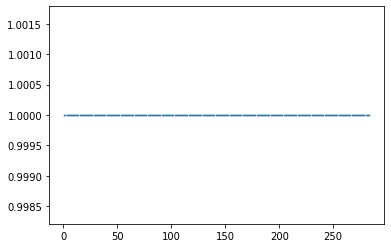

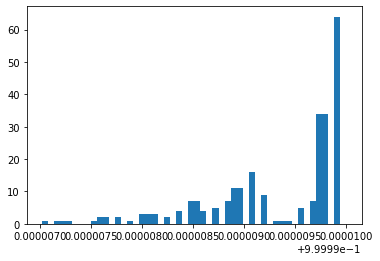

Average value is:  0.99999946
Total Predicted Positive:  179  out of  283
63.25088339222616 %
Epoch:  3
Train on 423 samples, validate on 283 samples
Epoch 1/1
423/423 [==============================] - 1s 2ms/step - loss: 5.3802e-06 - acc: 1.0000 - val_loss: 4.9411e-07 - val_acc: 1.0000
(283, 1)


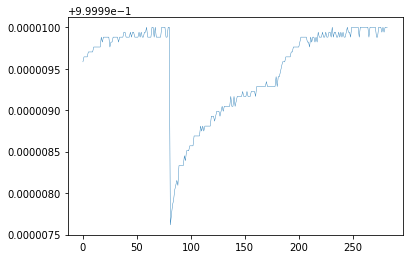

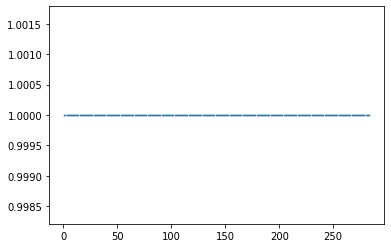

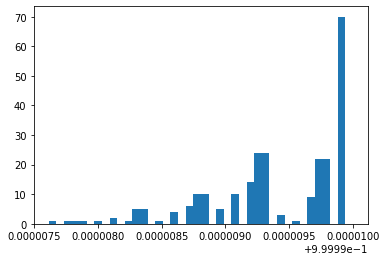

Average value is:  0.9999996
Total Predicted Positive:  179  out of  283
63.25088339222616 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 4
## create the model
modelCNN4 = 0
modelCNN4 = Sequential()
modelCNN4.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN4.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN4.add(Flatten())
modelCNN4.add(Dense(1, activation='sigmoid'))
modelCNN4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN4.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN4.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN4.fit(X_train4, y_train4, epochs=1, batch_size=batch_size_user, validation_data = (X_val4, y_val4),verbose=1)

  # Test the model
  y_pred = modelCNN4.predict(X_val4)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 564 samples, validate on 142 samples
Epoch 1/1
564/564 [==============================] - 2s 3ms/step - loss: 0.0170 - acc: 1.0000 - val_loss: 1.6756e-06 - val_acc: 1.0000
(142, 1)


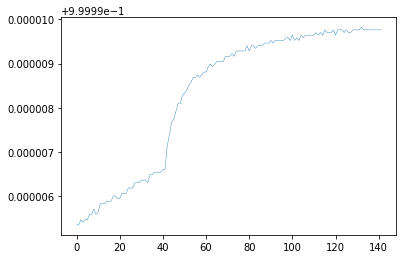

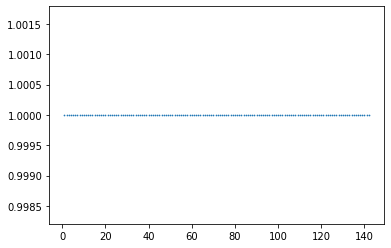

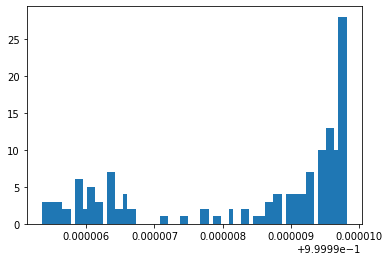

Average value is:  0.9999983
Total Predicted Positive:  93  out of  142
65.49295774647888 %
Epoch:  2
Train on 564 samples, validate on 142 samples
Epoch 1/1
564/564 [==============================] - 1s 2ms/step - loss: 1.4211e-05 - acc: 1.0000 - val_loss: 8.7560e-07 - val_acc: 1.0000
(142, 1)


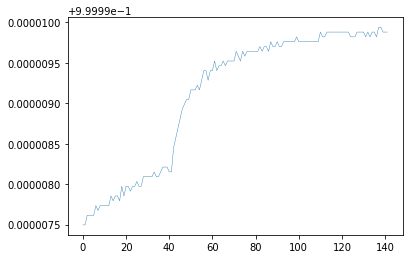

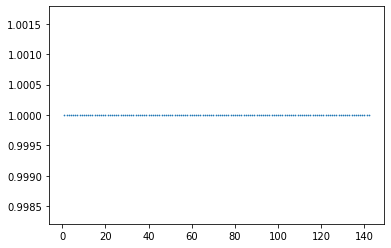

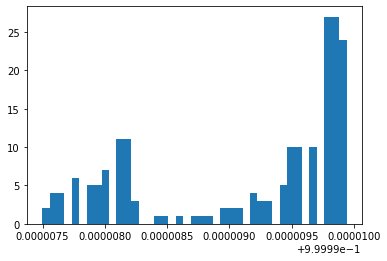

Average value is:  0.99999917
Total Predicted Positive:  92  out of  142
64.7887323943662 %
Epoch:  3
Train on 564 samples, validate on 142 samples
Epoch 1/1
564/564 [==============================] - 1s 2ms/step - loss: 7.9338e-06 - acc: 1.0000 - val_loss: 5.2217e-07 - val_acc: 1.0000
(142, 1)


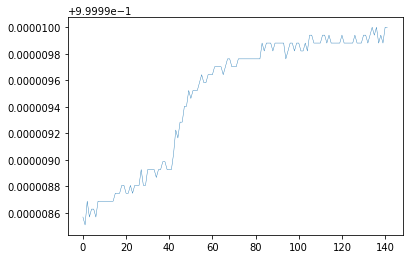

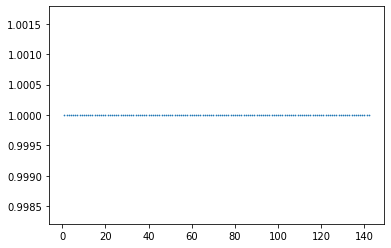

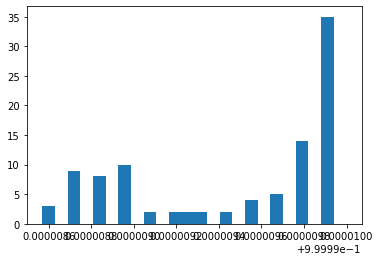

Average value is:  0.9999996
Total Predicted Positive:  88  out of  142
61.97183098591549 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 5
## create the model
modelCNN5 = 0
modelCNN5 = Sequential()
modelCNN5.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN5.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN5.add(Flatten())
modelCNN5.add(Dense(1, activation='sigmoid'))
modelCNN5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN5.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN5.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN5.fit(X_train5, y_train5, epochs=1, batch_size=batch_size_user, validation_data = (X_val5, y_val5),verbose=1)

  # Test the model
  y_pred = modelCNN5.predict(X_val5)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 695 samples, validate on 11 samples
Epoch 1/1
695/695 [==============================] - 2s 3ms/step - loss: 0.0135 - acc: 0.9986 - val_loss: 1.1921e-07 - val_acc: 1.0000
(11, 1)


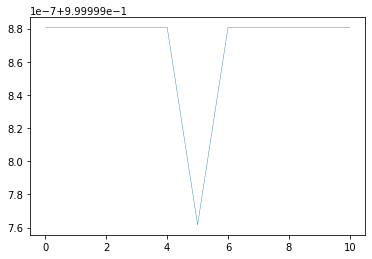

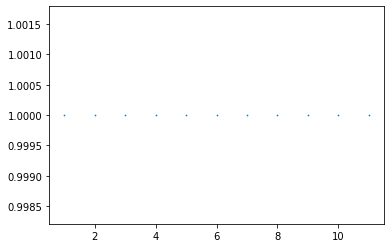

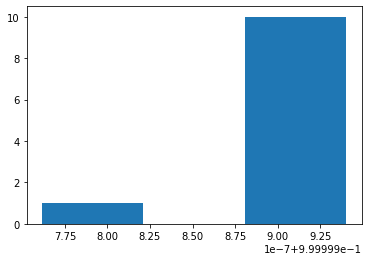

Average value is:  0.99999994
Total Predicted Positive:  0  out of  11
0.0 %
Epoch:  2
Train on 695 samples, validate on 11 samples
Epoch 1/1
695/695 [==============================] - 1s 2ms/step - loss: 8.7827e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
(11, 1)


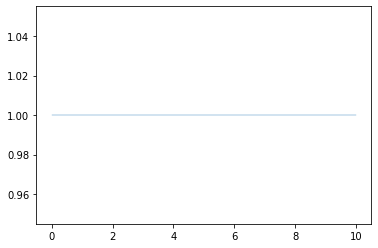

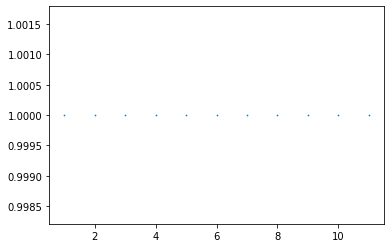

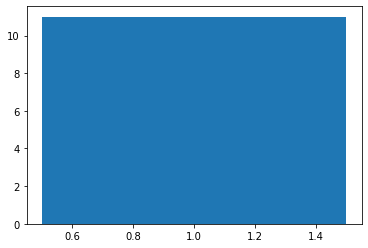

Average value is:  0.99999994
Total Predicted Positive:  0  out of  11
0.0 %
Epoch:  3
Train on 695 samples, validate on 11 samples
Epoch 1/1
695/695 [==============================] - 1s 2ms/step - loss: 4.5473e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
(11, 1)


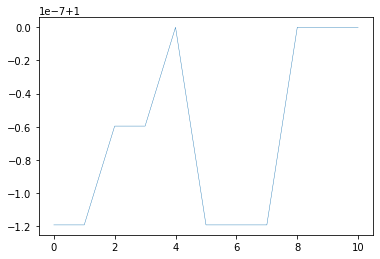

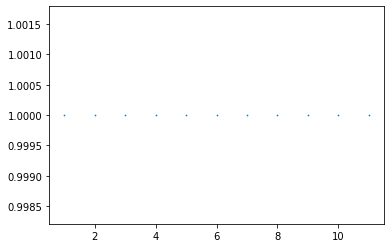

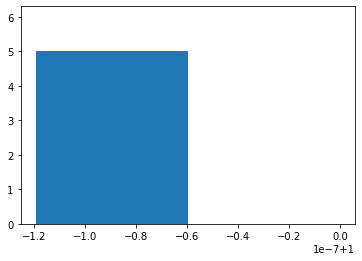

Average value is:  0.99999994
Total Predicted Positive:  6  out of  11
54.54545454545454 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 6
## create the model
modelCNN6 = 0
modelCNN6 = Sequential()
modelCNN6.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN6.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN6.add(Flatten())
modelCNN6.add(Dense(1, activation='sigmoid'))
modelCNN6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN6.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN6.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN6.fit(X_train6, y_train6, epochs=1, batch_size=batch_size_user, validation_data = (X_val6, y_val6),verbose=1)

  # Test the model
  y_pred = modelCNN6.predict(X_val6)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 3 samples, validate on 703 samples
Epoch 1/1
3/3 [==============================] - 2s 518ms/step - loss: 0.6760 - acc: 0.6667 - val_loss: 0.5410 - val_acc: 1.0000
(703, 1)


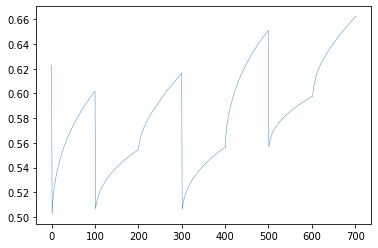

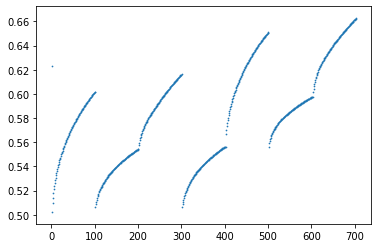

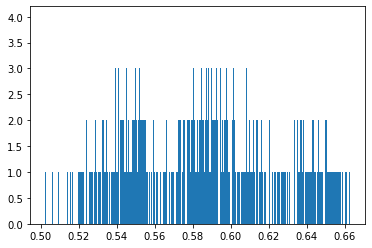

Average value is:  0.58350176
Total Predicted Positive:  358  out of  703
50.924608819345664 %
Epoch:  2
Train on 3 samples, validate on 703 samples
Epoch 1/1
3/3 [==============================] - 1s 213ms/step - loss: 0.5473 - acc: 1.0000 - val_loss: 0.4163 - val_acc: 1.0000
(703, 1)


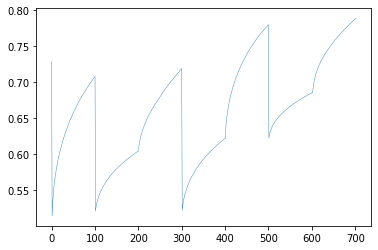

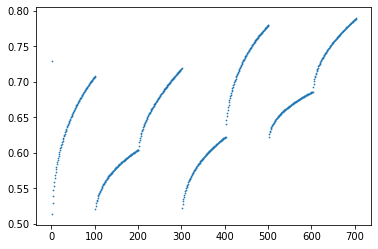

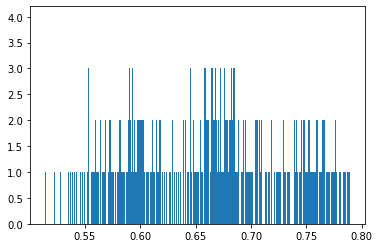

Average value is:  0.66303355
Total Predicted Positive:  371  out of  703
52.773826458036986 %
Epoch:  3
Train on 3 samples, validate on 703 samples
Epoch 1/1
3/3 [==============================] - 1s 235ms/step - loss: 0.4186 - acc: 1.0000 - val_loss: 0.2991 - val_acc: 1.0000
(703, 1)


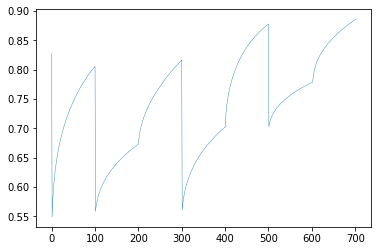

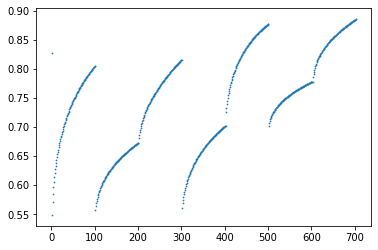

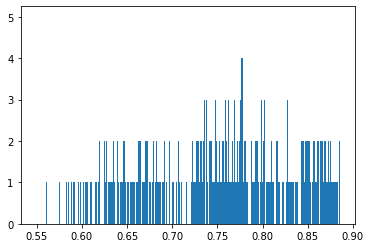

Average value is:  0.746229
Total Predicted Positive:  388  out of  703
55.19203413940256 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 7
## create the model
modelCNN7 = 0
modelCNN7 = Sequential()
modelCNN7.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN7.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN7.add(Flatten())
modelCNN7.add(Dense(1, activation='sigmoid'))
modelCNN7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN7.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN7.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN7.fit(X_train7, y_train7, epochs=1, batch_size=batch_size_user, validation_data = (X_val7, y_val7),verbose=1)

  # Test the model
  y_pred = modelCNN7.predict(X_val7)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

In [0]:
###########################################################################################################################
#------------------------------------------------------------RNN Model-----------------------------------------------#
###########################################################################################################################

In [0]:
# User defined parameters, for RNN particularly
# https://datascience.stackexchange.com/questions/20442/recurrent-neural-network-producing-same-predictions
# Has suggested that increasing batch size will help RNN stop predicting the same value for all
batch_size_user = 150
#epoch_user = 1
#times_to_loop_model = 5

print("User defined parameters set")
print(batch_size_user)
print(epoch_user)
print(times_to_loop_model)

User defined parameters set
150
1
3


In [0]:
print(input_shape)
print(flatten_shape)

(None, 100, 200, 3)
(None, 20000, 3)


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 2)                 48        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 1 samples, validate on 705 samples
Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 0.6931 - acc: 0.0000e+00 - val_loss: 0.6893 - val_acc: 1.0000
(705, 1)


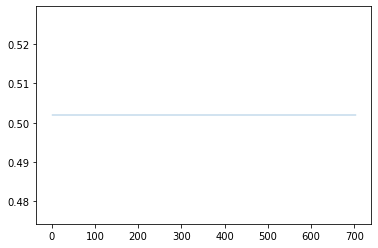

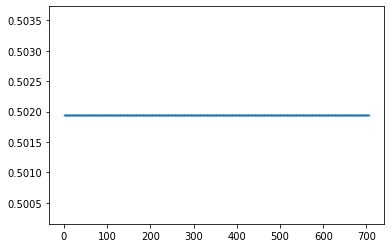

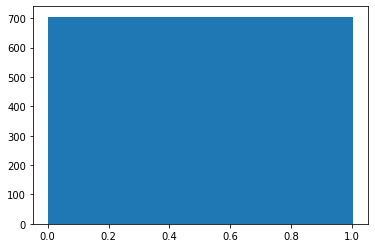

Average value is:  0.5019431
Total Predicted Positive:  0  out of  705
0.0 %
Epoch:  2
Train on 1 samples, validate on 705 samples
Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 0.6893 - acc: 1.0000 - val_loss: 0.6854 - val_acc: 1.0000
(705, 1)


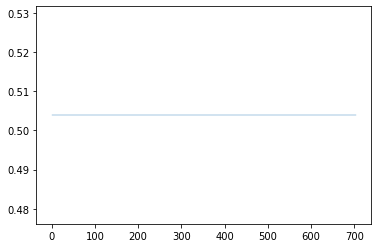

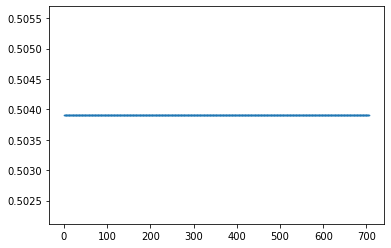

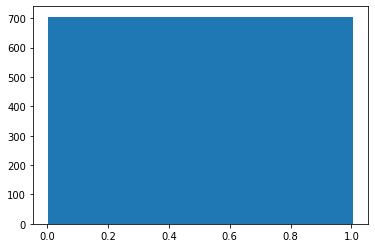

Average value is:  0.50390714
Total Predicted Positive:  705  out of  705
100.0 %
Epoch:  3
Train on 1 samples, validate on 705 samples
Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 0.6854 - acc: 1.0000 - val_loss: 0.6814 - val_acc: 1.0000
(705, 1)


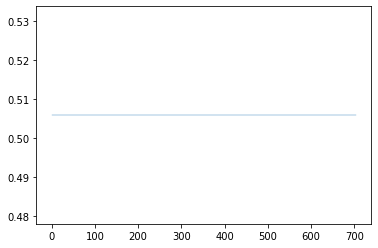

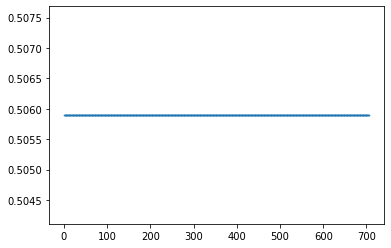

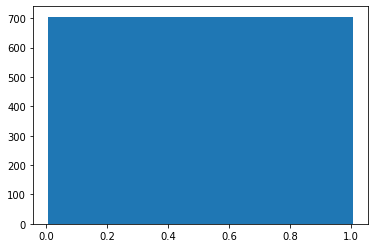

Average value is:  0.50589645
Total Predicted Positive:  0  out of  705
0.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 1
## create the model
modelRNNLSTM1 = 0
modelRNNLSTM1 = Sequential()
modelRNNLSTM1.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM1.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM1.add(Dense(1, activation='sigmoid'))
modelRNNLSTM1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM1.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM1.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM1.fit(X_train1_flatten, y_train1, epochs=1, batch_size=batch_size_user, validation_data = (X_val1_flatten, y_val1),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM1.predict(X_val1_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_3 (CuDNNLSTM)     (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 2)                 48        
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 141 samples, validate on 565 samples
Epoch 1/1
141/141 [==============================] - 5s 37ms/step - loss: 0.6931 - acc: 0.0000e+00 - val_loss: 0.6903 - val_acc: 1.0000
(565, 1)


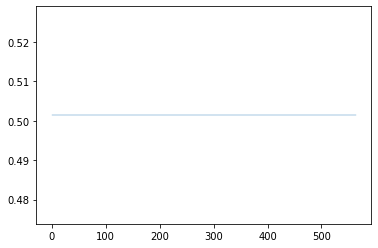

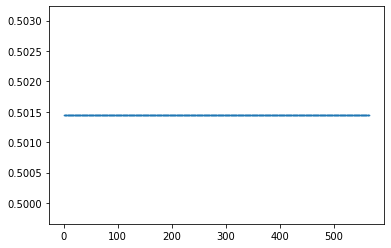

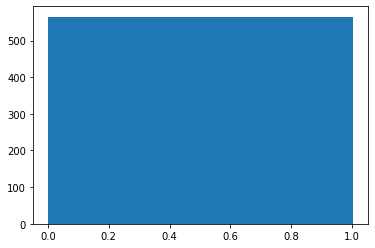

Average value is:  0.501446
Total Predicted Positive:  565  out of  565
100.0 %
Epoch:  2
Train on 141 samples, validate on 565 samples
Epoch 1/1
141/141 [==============================] - 4s 26ms/step - loss: 0.6903 - acc: 1.0000 - val_loss: 0.6869 - val_acc: 1.0000
(565, 1)


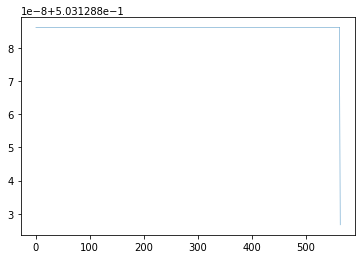

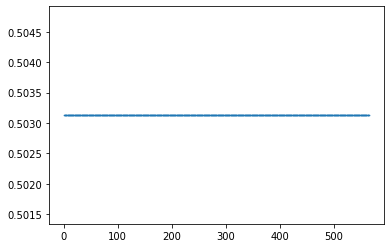

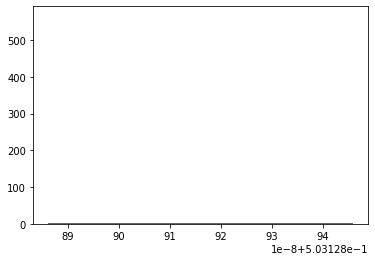

Average value is:  0.50312895
Total Predicted Positive:  0  out of  565
0.0 %
Epoch:  3
Train on 141 samples, validate on 565 samples
Epoch 1/1
141/141 [==============================] - 4s 27ms/step - loss: 0.6869 - acc: 1.0000 - val_loss: 0.6833 - val_acc: 1.0000
(565, 1)


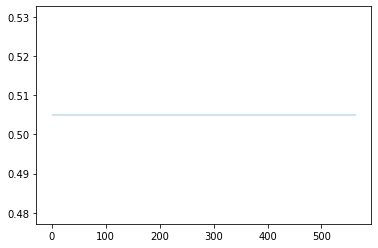

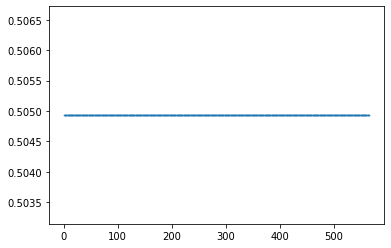

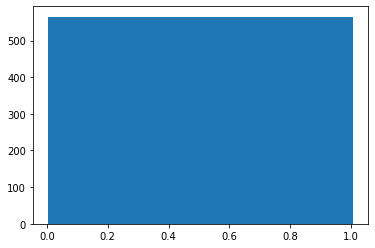

Average value is:  0.504932
Total Predicted Positive:  565  out of  565
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 2
## create the model
modelRNNLSTM2 = 0
modelRNNLSTM2 = Sequential()
modelRNNLSTM2.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM2.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM2.add(Dense(1, activation='sigmoid'))
modelRNNLSTM2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM2.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM2.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM2.fit(X_train2_flatten, y_train2, epochs=1, batch_size=batch_size_user, validation_data = (X_val2_flatten, y_val2),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM2.predict(X_val2_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_5 (CuDNNLSTM)     (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 2)                 48        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 282 samples, validate on 424 samples
Epoch 1/1
282/282 [==============================] - 5s 19ms/step - loss: 0.6913 - acc: 0.4681 - val_loss: 0.6854 - val_acc: 1.0000
(424, 1)


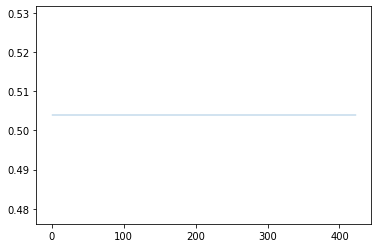

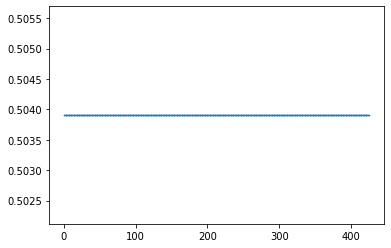

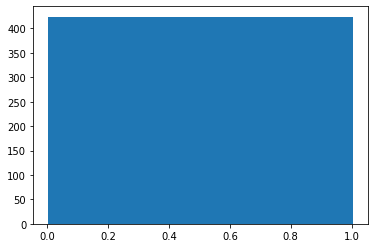

Average value is:  0.5039072
Total Predicted Positive:  0  out of  424
0.0 %
Epoch:  2
Train on 282 samples, validate on 424 samples
Epoch 1/1
282/282 [==============================] - 4s 14ms/step - loss: 0.6835 - acc: 1.0000 - val_loss: 0.6774 - val_acc: 1.0000
(424, 1)


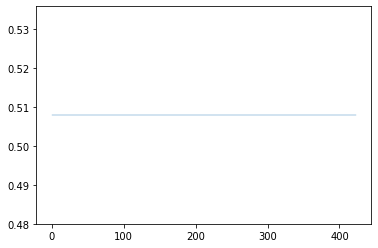

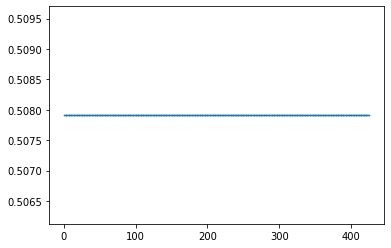

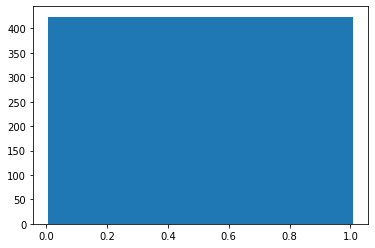

Average value is:  0.50791174
Total Predicted Positive:  424  out of  424
100.0 %
Epoch:  3
Train on 282 samples, validate on 424 samples
Epoch 1/1
282/282 [==============================] - 4s 14ms/step - loss: 0.6756 - acc: 1.0000 - val_loss: 0.6694 - val_acc: 1.0000
(424, 1)


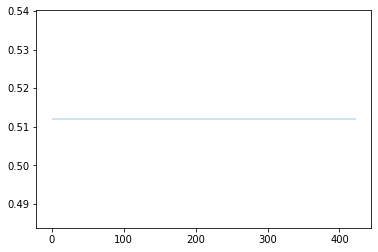

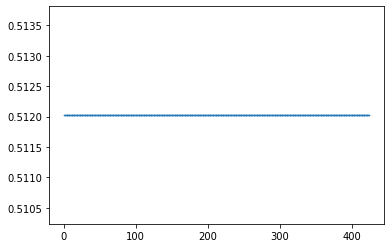

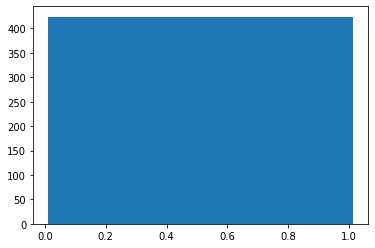

Average value is:  0.512024
Total Predicted Positive:  424  out of  424
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 3
## create the model
modelRNNLSTM3 = 0
modelRNNLSTM3 = Sequential()
modelRNNLSTM3.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM3.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM3.add(Dense(1, activation='sigmoid'))
modelRNNLSTM3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM3.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM3.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM3.fit(X_train3_flatten, y_train3, epochs=1, batch_size=batch_size_user, validation_data = (X_val3_flatten, y_val3),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM3.predict(X_val3_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_7 (CuDNNLSTM)     (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 2)                 48        
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 423 samples, validate on 283 samples
Epoch 1/1
423/423 [==============================] - 7s 17ms/step - loss: 0.6903 - acc: 0.6454 - val_loss: 0.6833 - val_acc: 1.0000
(283, 1)


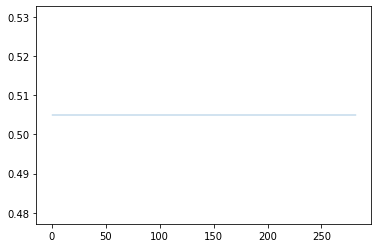

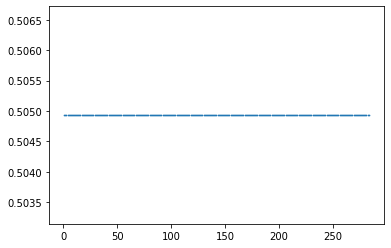

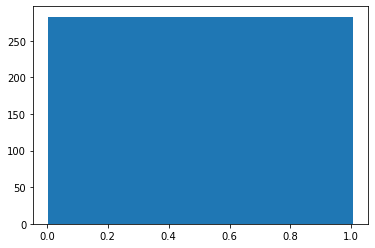

Average value is:  0.504932
Total Predicted Positive:  283  out of  283
100.0 %
Epoch:  2
Train on 423 samples, validate on 283 samples
Epoch 1/1
423/423 [==============================] - 5s 13ms/step - loss: 0.6798 - acc: 1.0000 - val_loss: 0.6719 - val_acc: 1.0000
(283, 1)


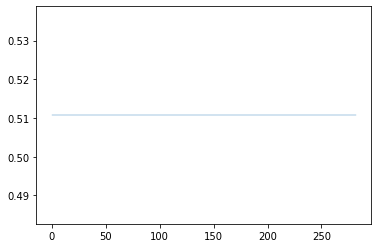

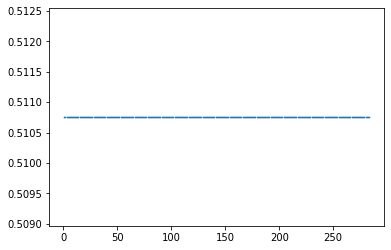

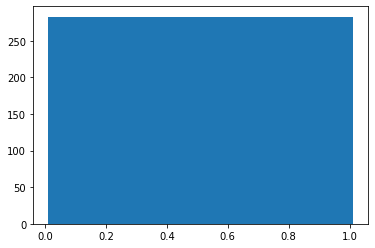

Average value is:  0.5107555
Total Predicted Positive:  0  out of  283
0.0 %
Epoch:  3
Train on 423 samples, validate on 283 samples
Epoch 1/1
423/423 [==============================] - 5s 13ms/step - loss: 0.6681 - acc: 1.0000 - val_loss: 0.6597 - val_acc: 1.0000
(283, 1)


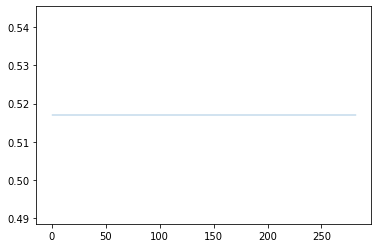

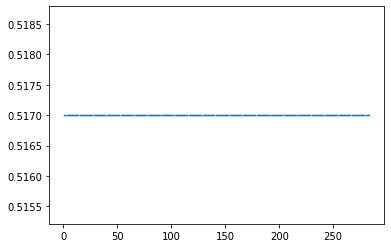

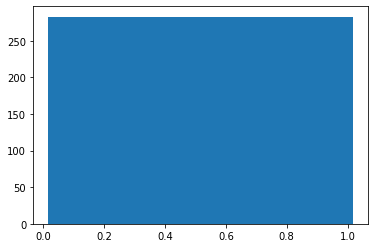

Average value is:  0.5170016
Total Predicted Positive:  283  out of  283
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 4
## create the model
modelRNNLSTM4 = 0
modelRNNLSTM4 = Sequential()
modelRNNLSTM4.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM4.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM4.add(Dense(1, activation='sigmoid'))
modelRNNLSTM4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM4.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM4.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM4.fit(X_train4_flatten, y_train4, epochs=1, batch_size=batch_size_user, validation_data = (X_val4_flatten, y_val4),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM4.predict(X_val4_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_9 (CuDNNLSTM)     (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (None, 2)                 48        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 564 samples, validate on 142 samples
Epoch 1/1
564/564 [==============================] - 7s 13ms/step - loss: 0.6887 - acc: 0.7340 - val_loss: 0.6796 - val_acc: 1.0000
(142, 1)


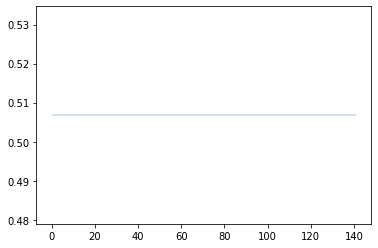

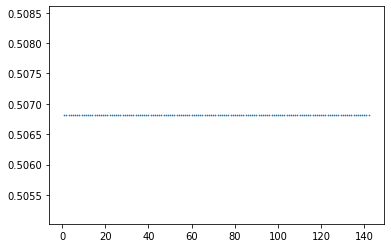

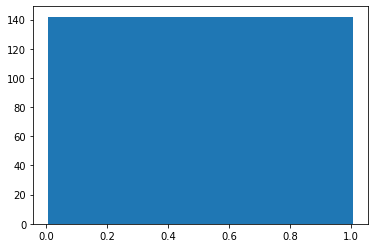

Average value is:  0.50681525
Total Predicted Positive:  0  out of  142
0.0 %
Epoch:  2
Train on 564 samples, validate on 142 samples
Epoch 1/1
564/564 [==============================] - 5s 9ms/step - loss: 0.6742 - acc: 1.0000 - val_loss: 0.6638 - val_acc: 1.0000
(142, 1)


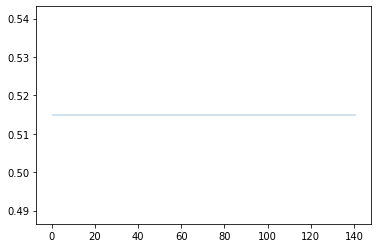

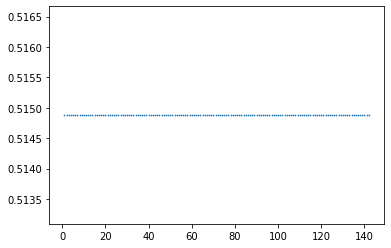

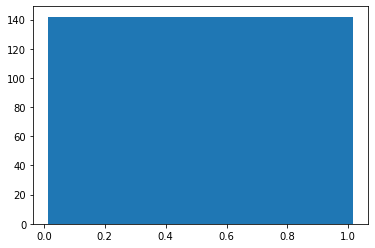

Average value is:  0.5148796
Total Predicted Positive:  0  out of  142
0.0 %
Epoch:  3
Train on 564 samples, validate on 142 samples
Epoch 1/1
564/564 [==============================] - 5s 9ms/step - loss: 0.6580 - acc: 1.0000 - val_loss: 0.6471 - val_acc: 1.0000
(142, 1)


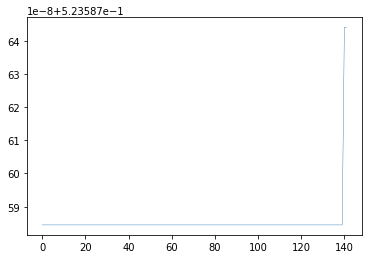

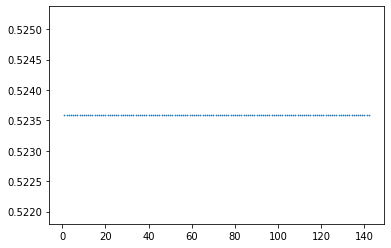

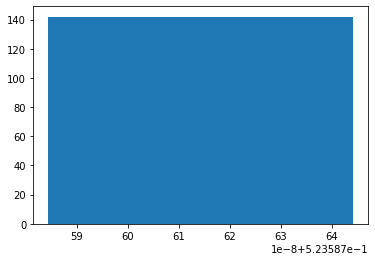

Average value is:  0.52358764
Total Predicted Positive:  2  out of  142
1.4084507042253522 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 5
## create the model
modelRNNLSTM5 = 0
modelRNNLSTM5 = Sequential()
modelRNNLSTM5.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM5.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM5.add(Dense(1, activation='sigmoid'))
modelRNNLSTM5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM5.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM5.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM5.fit(X_train5_flatten, y_train5, epochs=1, batch_size=batch_size_user, validation_data = (X_val5_flatten, y_val5),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM5.predict(X_val5_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_11 (CuDNNLSTM)    (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_12 (CuDNNLSTM)    (None, 2)                 48        
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 695 samples, validate on 11 samples
Epoch 1/1
695/695 [==============================] - 9s 13ms/step - loss: 0.6860 - acc: 0.7842 - val_loss: 0.6734 - val_acc: 1.0000
(11, 1)


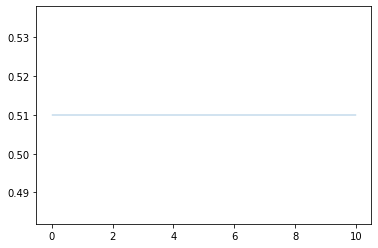

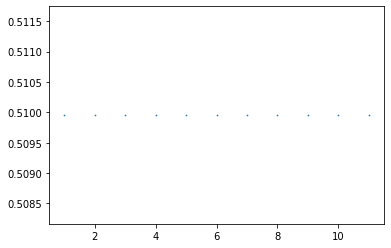

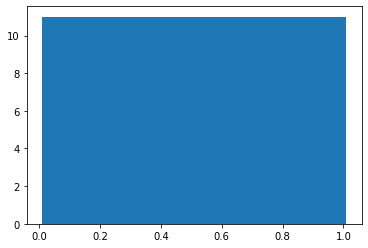

Average value is:  0.5099541
Total Predicted Positive:  11  out of  11
100.0 %
Epoch:  2
Train on 695 samples, validate on 11 samples
Epoch 1/1
695/695 [==============================] - 7s 10ms/step - loss: 0.6659 - acc: 1.0000 - val_loss: 0.6528 - val_acc: 1.0000
(11, 1)


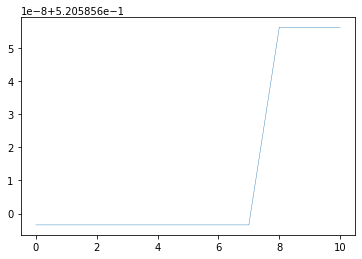

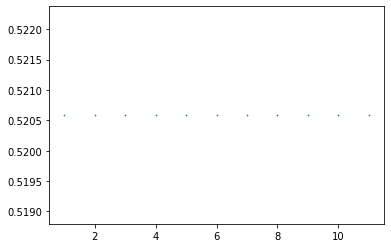

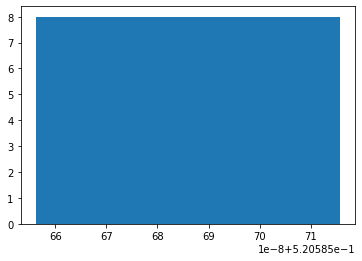

Average value is:  0.5205856
Total Predicted Positive:  11  out of  11
100.0 %
Epoch:  3
Train on 695 samples, validate on 11 samples
Epoch 1/1
695/695 [==============================] - 7s 10ms/step - loss: 0.6449 - acc: 1.0000 - val_loss: 0.6312 - val_acc: 1.0000
(11, 1)


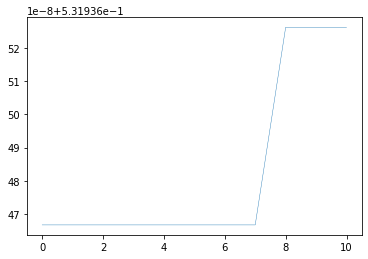

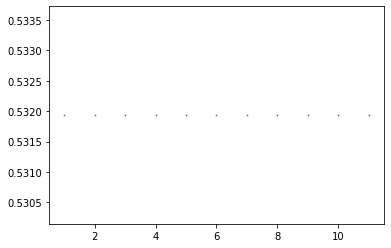

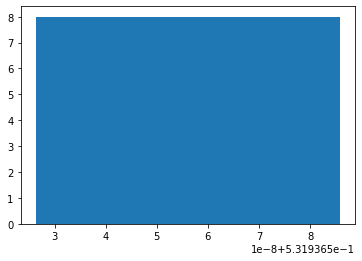

Average value is:  0.5319365
Total Predicted Positive:  3  out of  11
27.27272727272727 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 6
## create the model
modelRNNLSTM6 = 0
modelRNNLSTM6 = Sequential()
modelRNNLSTM6.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM6.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM6.add(Dense(1, activation='sigmoid'))
modelRNNLSTM6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM6.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM6.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM6.fit(X_train6_flatten, y_train6, epochs=1, batch_size=batch_size_user, validation_data = (X_val6_flatten, y_val6),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM6.predict(X_val6_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_13 (CuDNNLSTM)    (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_14 (CuDNNLSTM)    (None, 2)                 48        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 3 samples, validate on 703 samples
Epoch 1/1
3/3 [==============================] - 6s 2s/step - loss: 0.6931 - acc: 0.0000e+00 - val_loss: 0.6903 - val_acc: 1.0000
(703, 1)


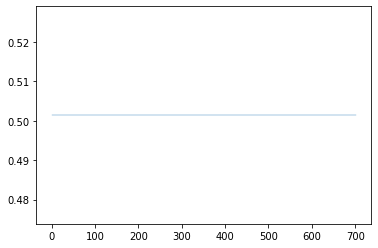

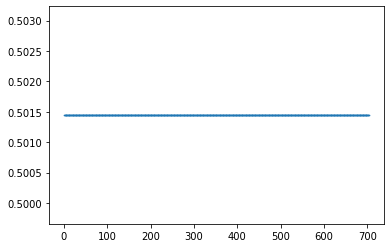

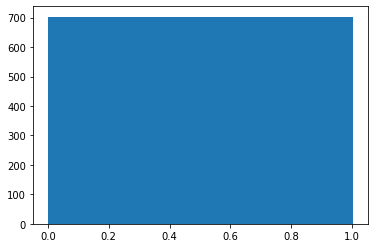

Average value is:  0.5014459
Total Predicted Positive:  703  out of  703
100.0 %
Epoch:  2
Train on 3 samples, validate on 703 samples
Epoch 1/1
3/3 [==============================] - 4s 1s/step - loss: 0.6903 - acc: 1.0000 - val_loss: 0.6869 - val_acc: 1.0000
(703, 1)


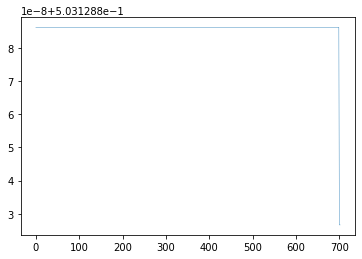

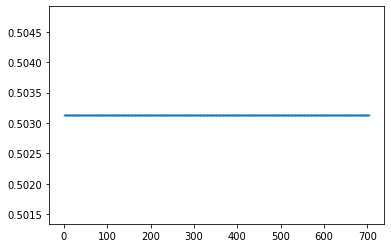

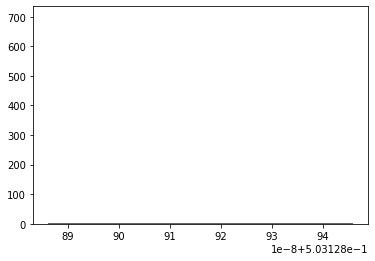

Average value is:  0.50312895
Total Predicted Positive:  0  out of  703
0.0 %
Epoch:  3
Train on 3 samples, validate on 703 samples
Epoch 1/1
3/3 [==============================] - 4s 1s/step - loss: 0.6869 - acc: 1.0000 - val_loss: 0.6833 - val_acc: 1.0000
(703, 1)


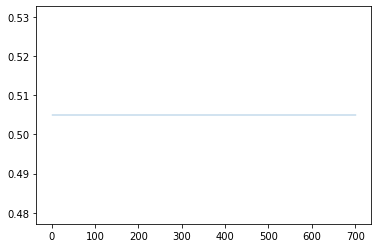

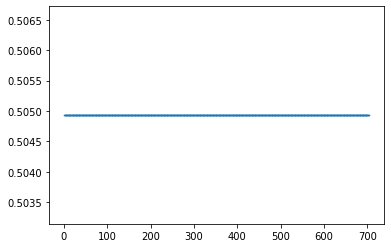

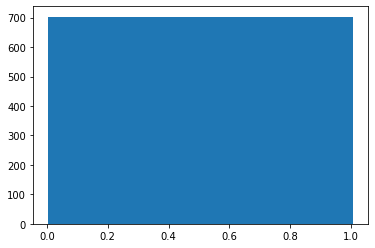

Average value is:  0.5049319
Total Predicted Positive:  703  out of  703
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 7
## create the model
modelRNNLSTM7 = 0
modelRNNLSTM7 = Sequential()
modelRNNLSTM7.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM7.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM7.add(Dense(1, activation='sigmoid'))
modelRNNLSTM7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM7.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM7.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM7.fit(X_train7_flatten, y_train7, epochs=1, batch_size=batch_size_user, validation_data = (X_val7_flatten, y_val7),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM7.predict(X_val7_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1